# ChIPAID project

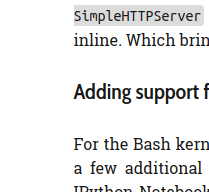

In [6]:
display < ./Picture/toto.png;

##### TODO

- End biblio on how to perform ChIP-Seq analysis
- Dedup BAM ?
- Launch peak calling
- Perform IDR & other controls
- DE analysis
- Si grosse != entre les IN => Why ?
- Eric enlèverrait les duplicats de PCR
- Impossible d'estimer par l'a priori la taille encombrée de l'ADN lors de l'IP, car AID pas en intéraction directe, mais avec un complexe qui lui est fixé sur ADN. D'ailleurs on va aussi IP des bouts d'ADN de ce complexe qui était en intéraction avec un autre locus d'ADN. (trucs qui, si on en avait la connaissance biologique, pourrait être vus sous IGV, genre quand AID est sur complexe en chr1:400, il y a fréquemment intéraction de ce complexe avec autre zone = chr4-8000 ou chr1-7000).
- Tester analyse sans Input (si input pas fiable ?)
- Dans locus IgH, tjs la pbmatique de mauvaise mapping à certains endroits (car soit répétitif, soit bcp trop de réarrangement dans les B cells activés sur locus IgH).
- AID peut avoir des peaks sharp et des broads, ça dépend.
- Comment tenir compte du ratio IP/IN qui n'est pas 50/50 niveau bio-mol ?
- Si analyse DE pas assez robuste, s'arrêter avant, cad juste call les peaks, sur les 6 samples (3 MAR, 3 WT, voir MAR-pool et WT-pool), puis sortir liste de peaks MAR spé, WT spé, et ceux qui sont vus dans les 2 mais qui semblent être != en force. Puis faire batch script IGV ?

## 0) Introduction

Context is B cells, focusing on SHM event and AID enzyme. <br>
ChIP-Seq is performed to look at AID recruitment on Ig genes & on AID off-target genes. <br>
In this study we have WT mouse & MAR-KO (MAR) mouse. <br>
It is expected that MAR have lower AID recruitement on IgH, IgK, IgL & AID off-target.

One of the issue is : B cells of interest are pretty rare & the AID enzyme events are pretty rare too. Thus we may not have enough data (compared to classical ChIP-Seq protocols).

Samples are : 3 biological rep for both WT & MAR (and all have immunoP (IP) + Input (IN) (control), for a total of 12 samples).

## 1) Data

### 1.1) Reads

Raw reads were retrieved from Ophélie Martin external drive. They were sequenced @FTS (@Lionel & @Romain) on Illumina plateform (75bp single-end).

##### FASTQ samples were barcoded, separated, cleaned but not merged
Thus we need to do this task

##### Get uniques IDs (should be 12)

In [ ]:
### CODE ###
path='/run/user/1000/gvfs/smb-share:server=ubox.ad.unilim.fr,share=biscem/BioInformatique/Responsables/Commun/CHIPAID';
cd $path/Data/Reads;
for f in *.gz;
do echo ${f%%_*};
done | sort -u > samples.txt;

##### Then cat the 48 files -> 12 FASTQ

In [ ]:
### CODE ###
while read sample;
do cat $sample* > $sample.fastq.gz;
done < samples.txt;

##### Lastly, use "easier" names for samples

In [ ]:
mv MARsKO01.fastq.gz MAR_IN_1.fastq.gz;
mv MARsKO02.fastq.gz MAR_IN_2.fastq.gz;
mv MARsKO03.fastq.gz MAR_IN_3.fastq.gz;
mv MARsKO1.fastq.gz MAR_IP_1.fastq.gz;
mv MARsKO2.fastq.gz MAR_IP_2.fastq.gz;
mv MARsKO3.fastq.gz MAR_IP_3.fastq.gz;
mv WT01.fastq.gz WT_IN_1.fastq.gz;
mv WT02.fastq.gz WT_IN_2.fastq.gz;
mv WT03.fastq.gz WT_IN_3.fastq.gz;
mv WT1.fastq.gz WT_IP_1.fastq.gz;
mv WT2.fastq.gz WT_IP_2.fastq.gz;
mv WT3.fastq.gz WT_IP_3.fastq.gz;

### 1.2) Mus musculus

Reference genome is the same as the one used in the PTCB project. It's the latest GRC (GRCm38.p6), minus entries not in the gencode M16 annotation (to avoid future fails with downstream analysis tools).

### 1.3) Blacklisted regions

In [ ]:
wget http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/mm10-mouse/mm10.blacklist.bed.gz;

### 1.4) Annotation tracks for IGV

#### 1.4.1) mm10 + custom IgH

##### Manually retrive latest custom primer position @Ophelie

- https://www.ensembl.org/Mus_musculus/Tools/Blast?db=core
- Search against Mus_musculus
- Search Tool : BLASTN
- Search Sensitivity : Near match <br>
Do this for the following primers : AS0, AS1, AS2, AS3 et S1, S2, S3, as described in fig_s3_locus_avec_primers_de_rt_et_probes.pdf

Then proceed to create custom annotation track for IGV

In [ ]:
### CODE ###
# Retrieve latest gencode annotation (M16)
url='ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_mouse/release_M16';
name='gencode.vM16.chr_patch_hapl_scaff';
axel -q $url/$name.annotation.gtf.gz;
unpigz $name.annotation.gtf.gz;

# Create a file with our custom annotations
touch custom_igh.gtf;
echo 'chr12 . hs7 113221438 113221581 . - . Name=hs7' >> custom_igh.gtf;
echo 'chr12 . hs6 113223561 113223688 . - . Name=hs6' >> custom_igh.gtf;
echo 'chr12 . hs5 113224745 113224923 . - . Name=hs5' >> custom_igh.gtf;
echo 'chr12 . hs4 113228349 113228519 . - . Name=hs4' >> custom_igh.gtf;
echo 'chr12 . hs3b 113232345 113232538 . - . Name=hs3b' >> custom_igh.gtf;
echo 'chr12 . hs1.2 113244593 113244972 . - . Name=hs1.2' >> custom_igh.gtf;
echo 'chr12 . hs3a 113253847 113254040 . - . Name=hs3a' >> custom_igh.gtf;
echo 'chr12 . HRE2 113315188 113314617 . - . Name=HRE2' >> custom_igh.gtf;
echo 'chr12 . HRE1 113320944 113321537 . - . Name=HRE1' >> custom_igh.gtf;
echo 'chr12 . IgD 113416247 113418359 . - . Name=IgD' >> custom_igh.gtf;
echo 'chr12 . Mar3 113426976 113427406 . - . Name=Mar3' >> custom_igh.gtf;
echo 'chr12 . cEµ 113427408 113427624 . - . Name=cEµ' >> custom_igh.gtf;
echo 'chr12 . Mar5 113427624 113427970 . - . Name=Mar5' >> custom_igh.gtf;
echo 'chr12 . primer_AS0 113429300 113429319 . - . Name=primer_AS0' >> custom_igh.gtf;
echo 'chr12 . primer_AS1 113428766 113428785 . - . Name=primer_AS1' >> custom_igh.gtf;
echo 'chr12 . primer_AS2 113428491 113428507 . - . Name=primer_AS2' >> custom_igh.gtf;
echo 'chr12 . primer_AS3 113428417 113428436 . - . Name=primer_AS3' >> custom_igh.gtf;
echo 'chr12 . primer_S1 113428372 113428393 . - . Name=primer_S1' >> custom_igh.gtf;
echo 'chr12 . primer_S2 113427973 113427996 . - . Name=primer_S2' >> custom_igh.gtf;
echo 'chr12 . primer_S3 113427554 113427574 . - . Name=primer_S3' >> custom_igh.gtf;
sed -i 's/ /\t/g' custom_igh.gtf;

# Unsorted concatenation of M16 + custom
cat $name".annotation.gtf" custom_igh.gtf > $name"_and_20_custom_igh.annotation.gtf";
rm $name".annotation.gtf" custom_igh.gtf;

# Sort with gff3sort (because GNU sort has a bug : Lines with the same chromosomes and start positions would be placed randomly)
file=$name'_and_20_custom_igh.annotation.gtf';
gff3sort.pl --precise --chr_order natural $file |bgzip > ${file%.annotation*}_gff3sort.annotation.gtf.gz;
tabix -p gff ${file%.annotation*}_gff3sort.annotation.gtf.gz;
rm $name'_and_20_custom_igh.annotation.gtf';

#### 1.4.2) mm9 (to view Casellas results)

In [ ]:
# Retrieve corresponding gencode annotation
# https://www.biostars.org/p/291445/
url='ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_mouse/release_M1';
name='gencode.vM1';
axel -q $url/$name.annotation.gtf.gz;
unpigz $name.annotation.gtf.gz;

# Sort with gff3sort (because GNU sort has a bug : Lines with the same chromosomes and start positions would be placed randomly)
gff3sort.pl --precise --chr_order natural $name.annotation.gtf |bgzip > $name"_gff3sort.annotation.gtf.gz";
tabix -p gff $name"_gff3sort.annotation.gtf.gz";
rm $name.annotation.gtf;

## 2) Quality control

##### FastQC v0.11.2 @genotoul

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=8G
#$ -l h_vmem=10G
#$ -N fastqc_chipaid
#$ -o /home/escaon/work/CHIPAID/Verbose/fastqc.o
#$ -e /home/escaon/work/CHIPAID/Verbose/fastqc.e

##############################
### Paths, tools & modules ###
##############################
work='/home/escaon/work/CHIPAID';

##############
### FASTQC ###
##############
cd $work/Data;
for f in *.fastq.gz;
do echo $f; fastqc --outdir $work -f fastq $f;
done;

##### MultiQC 1.4 @genotoul

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=8G
#$ -l h_vmem=10G
#$ -N multiqc_chipaid
#$ -o /home/escaon/work/CHIPAID/Verbose/multiqc.o
#$ -e /home/escaon/work/CHIPAID/Verbose/multiqc.e

##############################
### Paths, tools & modules ###
##############################
work='/home/escaon/work/CHIPAID';
fastqc_dir='/home/escaon/work/CHIPAID/QC/FastQC';

###############
### MULTIQC ###
###############
multiqc $fastqc_dir \
        -n chipaid \
        -o $work \
        -m fastqc \
        -f;

##### Thoughts on QC

3 biological rep for both WT & MAR, thus 6 intial samples to look at (same initial sample is splited to provide IN & IP) :

WT_1 :<br>
WT_IP_1 has bad sequence qual & under average read len (56).

WT_2 :<br>
WT_IN_2 has under average read len (61) and mixed sequence qual.
WT_IP_2 has a whooping 75.5M reads.

WT_3 :<br>
Seems good : ~24M reads in both IP & IN, ~75 len, good qual.

MAR_1 :<br>
MAR_IP_1 has bad seq qual and under average read len (57).
MAR_IN_1 has mixed sequence qual.

MAR_2 :<br>
MAR_IP_2 has abberant GC%, low lenght (mean 46 vs expected 75) and few sequences.<br>
Associated MAR_IN_2 has 190.5M sequences ! (with 75 len & good qual).<br>

MAR_3 :<br>
Seems good : ~70 len, good qual, 38.2M reads in IN and 4.5 in IP, which could be OK given the biological context (less IP expected in MAR).

## 3) Align reads vs reference genome

### 3.1) Build index

Given that reads are shorter here than in the PTCB project, let's rebuild the genome index with this in mind (sjdbOverhang parameter 150 -> 74)

##### STAR 2.5.3a @CALI

In [ ]:
### CODE ###
#!/bin/bash
#SBATCH --partition=normal
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=8
#SBATCH --mem-per-cpu=6144
#SBATCH --time=1-23:59:59
#SBATCH --mail-user=erwan.scaon@unilim.fr
#SBATCH --mail-type=begin
#SBATCH --mail-type=end
#SBATCH --error=/home/scaonp01/scratch/PTCB/Verbose/star_idx_custom_chipaid.e
#SBATCH --output=/home/scaonp01/scratch/PTCB/Verbose/star_idx_custom_chipaid.o
#SBATCH --job-name=star_idx_custom

##############################
### Paths, tools & modules ###
##############################
nt=8;
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK;
star='/home/scaonp01/Software/STAR_2.5.3a/bin/Linux_x86_64';
ptcb='/home/scaonp01/PTCB/Data/Mus_musculus';
scratch='/home/scaonp01/scratch/PTCB';

############
### STAR ###
############
mkdir -p $ptcb/GRCm38.p6_custom_chipaid_STAR;
cd $ptcb/GRCm38.p6_custom_chipaid_STAR;
$star/STAR --runThreadN $nt \
           --runMode genomeGenerate \
           --genomeDir $ptcb/GRCm38.p6_custom_chipaid_STAR \
           --genomeFastaFiles $ptcb/GRCm38.p6_custom_STAR/GCA_000001635.8_GRCm38.p6_genomic_renamed_subsampled.fna \
           --sjdbGTFfile $ptcb/GRCm38.p6_custom_STAR/gencode.vM16.chr_patch_hapl_scaff.annotation.gtf \
           --sjdbOverhang 74;

### 3.2) Alignments

##### STAR 2.5.3a @CALI

Initial script : star_WT_IN_2.sh <br>
Nb_1 : We use gapped aligner based on biostar handbook advise. <br>
Nb_2 : Default parameters (Did not find any guidelines for ChIP-Seq such as Encode alignement parameters advise for RNA-Seq). <br>
Nb_3 : We keep unaligned reads in a separated FASTQ just in case.

In [ ]:
### CODE ###
#!/bin/bash
#SBATCH --partition=normal
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=8
#SBATCH --mem-per-cpu=6144
#SBATCH --time=1-23:59:59
#SBATCH --mail-user=erwan.scaon@unilim.fr
#SBATCH --mail-type=BEGIN
#SBATCH --mail-type=END
#SBATCH --error=/home/scaonp01/scratch/CHIPAID/Verbose/star_WT_IN_2.e
#SBATCH --output=/home/scaonp01/scratch/CHIPAID/Verbose/star_WT_IN_2.o
#SBATCH --job-name=star_WT_IN_2

##############################
### Paths, tools & modules ###
##############################
nt=8;
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK;
star='/home/scaonp01/Software/STAR_2.5.3a/bin/Linux_x86_64/STAR';
samtools='/home/scaonp01/Software/Samtools_1.6/Install/bin/samtools';
save='/home/scaonp01/CHIPAID';
work='/home/scaonp01/scratch/CHIPAID';

############
### STAR ###
############
cd $save/Data/Reads;
for id in 'WT_IN_2';
do $star --genomeDir $save/Data/GRCm38.p6_custom_chipaid_STAR \
         --readFilesIn $id.fastq.gz \
         --outFileNamePrefix $work/$id"_vs_GRCm38.p6_custom_" \
         --runThreadN $nt \
         --readFilesCommand zcat \
         --outSAMtype BAM SortedByCoordinate \
         --outReadsUnmapped Fastx;
done;

######################
### Compress Stuff ###
######################
cd $work;
mv $id"_vs_GRCm38.p6_custom_Unmapped.out.mate1" $id"_vs_GRCm38.p6_custom_Unmapped.out.mate1.fastq";
gzip $id"_vs_GRCm38.p6_custom_Unmapped.out.mate1.fastq";
$samtools index $id"_vs_GRCm38.p6_custom_Aligned.sortedByCoord.out.bam";

Duplicate script for the 11 other samples

In [ ]:
### CODE ###
for id in 'MAR_IN_1' 'MAR_IN_2' 'MAR_IN_3' 'MAR_IP_1' 'MAR_IP_2' 'MAR_IP_3' 'WT_IN_1' 'WT_IN_3' 'WT_IP_1' 'WT_IP_2' 'WT_IP_3';
do cp star_WT_IN_2.sh star_$id.sh;
   sed -i "s/WT_IN_2/$id/" star_$id.sh;
   sbatch star_$id.sh;
done;

### 3.3) Alignements QC

##### MultiQC 1.4 @local

In [ ]:
### CODE ###
path='/run/user/1000/gvfs/smb-share:server=ubox.ad.unilim.fr,share=biscem/BioInformatique/Responsables/Commun/CHIPAID';
cd $path/Output/1_STAR/QC;
multiqc ./ -n star_vs_custom -o ./ -m star -f > ./multiqc.verbose 2>&1;

## 4) Number of alignments per region of interest

Given the potential low throughput of this ChIP-Seq experiment, we want to check if we have enough alignments on known regions of interest.  <br>

Those regions are IgH, IgK & IgL loci : <br>
https://www.ncbi.nlm.nih.gov/gene/111507 <br>
https://www.ncbi.nlm.nih.gov/gene/243469 <br>
https://www.ncbi.nlm.nih.gov/gene/111519 <br>
chr6:67555636-70726754	IgK <br>
chr12:113258768-116009954	IgH <br>
chr16:19026858-19260844 IgL <br>

And genes of interest (105) in the context of MAR-KO mutant, previously created for the PTCB project (genes_of_interest_mar.tsv) : <br>
All members of the ARID family <br>
All members of thee SATB family <br>
Cux1 <br>
AID off targets genes in Liu et al., Nature Letters, 02/2008, Supp Fig1 <br>
Genes on the first page of Yamane et al., Nature Immunology, 01/2011, S1 Table <br>

### 4.1) Get "chr", "start", "end" and "gene_name" for each of the 105 gene_id

In [ ]:
### CODE ###
R;
library('biomaRt')
mar_goi=read.table("./genes_of_interest_mar.tsv")
colnames(mar_goi)[1] <- 'ensembl_gene_id'

mmusculus = useMart("ENSEMBL_MART_ENSEMBL",
                    dataset="mmusculus_gene_ensembl")

mm_infos <- getBM(attributes=c('ensembl_gene_id',
                               'chromosome_name',
                               'start_position',
                               'end_position',
                               'external_gene_name'),
                  mart = mmusculus)

mar_bed <- merge(x = mar_goi,
                 y = mm_infos,
                 by = "ensembl_gene_id",
                 all.x = TRUE)

write.table(mar_bed,
            file='./mar_goi_2.tsv',
            row.names=FALSE,
            col.names=FALSE,
            sep="\t")

##### Check coherence between biomart (ensembl) & GRC seqs names (in BAM / ref genome) <br>
In mar_goi.tsv : "1" ... "19" "X" <br>
In bam : >chr1, >GL456210.1, >GL456211.1 <br>

Thus it's okay, nothing special in goi, just need to add "chr".

### 4.2) Create BED for bedtools multicov

##### Add chr & move col 1 to col 4 (bed format is chr, start, end, name)

In [ ]:
### CODE ###
awk -F '\t' -vOFS='\t' '{print $2, $3, $4, $5}' mar_goi_2.tsv > temp_1.tsv;
awk -F '\t' -vOFS='\t' '{$1 = "chr"$1}1' temp_1.tsv > temp_2.tsv;
sed -i 's/\"//g' temp_2.tsv;
# Add IgH, IgK and IgL loci manually
# And sort BED, otherwise we will get error with downstream tools
sort -k2,2n -k3,3n temp_2.tsv > temp_3.tsv;
sort -V -k1 temp_3.tsv > mar_goi_2.bed;

### 4.3) Get number of alignments per regions in our BED

##### bedtools v2.25.0 @local

https://bedtools.readthedocs.io/en/latest/content/tools/multicov.html

In [ ]:
### CODE ###
# bamlist <=> ls -1 *.bam in BAM folder @CALI
bedtools multicov \
         -bams `cat bamlist.txt` \
         -bed mar_goi_2_igx.bed \
         > alignments_per_region.tsv;
sed -i '1 i\chr\tstart\tend\tgene\tMAR_IN_1\tMAR_IN_2\tMAR_IN_3\tMAR_IP_1\tMAR_IP_2\tMAR_IP_3\tWT_IN_1\tWT_IN_2\tWT_IN_3\tWT_IP_1\tWT_IP_2\tWT_IP_3' alignments_per_region.tsv;